In [245]:
import os, gc, sys
import pygrib
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import multiprocessing as mp
import matplotlib.pyplot as plt 

from glob import glob
from functools import partial
from matplotlib import gridspec
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable

os.environ['OMP_NUM_THREADS'] = '1'

In [237]:
# CONFIG # # CONFIG # # CONFIG # # CONFIG # # CONFIG # 
cwa = 'WESTUS'#sys.argv[1]
fhr_start, fhr_end, fhr_step = 24, 108, 6

start_date = datetime(2020, 5, 18, 0)
end_date = datetime(2020, 9, 30, 0)

produce_thresholds = [0.01, 0.25, 0.50]
bint, bins_custom = 5, None

cwa_bounds = {
    'WESTUS':[30, 50, -130, -100],
    'SEW':[46.0, 49.0, -125.0, -120.5],
    'SLC':[37.0, 42.0, -114.0, -110],
    'MSO':[44.25, 49.0, -116.75, -112.25],
    'MTR':[35.75, 38.75, -123.5, -120.25],}
# CONFIG # # CONFIG # # CONFIG # # CONFIG # # CONFIG # 

In [238]:
nbm_dir = '/scratch/general/lustre/u1070830/nbm/'
urma_dir = '/scratch/general/lustre/u1070830/urma/'
tmp_dir = '/scratch/general/lustre/u1070830/tmp/'
fig_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/'
os.makedirs(tmp_dir, exist_ok=True)

In [239]:
def calc_pbin(pbin, _bint, _thresh, _data, _urma):

    p0, p1 = pbin-_bint/2, pbin+_bint/2
    N = xr.where((_data >= p0) & (_data < p1), 1, 0).sum(dim=['valid'])
    n = xr.where((_data >= p0) & (_data < p1) & (_urma > _thresh), 1, 0).sum(dim='valid')
    
    return pbin, n, N

def calc_pbin_fixed(pbin, _thresh, _data, _urma):

    p0, p1 = pbin
    N = xr.where((_data >= p0) & (_data <= p1), 1, 0).sum(dim=['valid'])
    n = xr.where((_data >= p0) & (_data <= p1) & (_urma > _thresh), 1, 0).sum(dim='valid')
    
    return pbin, n, N

In [240]:
extract_dir = nbm_dir + 'extract/'
extract_flist = sorted(glob(extract_dir + '*'))

if not os.path.isfile(urma_dir + 'agg/urma_agg.nc'):
    pass 
    #print('URMA aggregate not found')

else:
    #print('Getting URMA aggregate from file')
    urma_whole = xr.open_dataset(urma_dir + 'agg/urma_agg.nc')['apcp24h_mm']

urma_whole = urma_whole/25.4
urma_whole = urma_whole.rename('apcp24h_in')

In [ ]:
geodir = '../forecast-zones/'
zones_shapefile = glob(geodir + '*.shp')[0]

# Read the shapefile
zones = gpd.read_file(zones_shapefile)

# Prune to Western Region using TZ
zones = zones.set_index('TIME_ZONE').loc[['M', 'Mm', 'm', 'MP', 'P']].reset_index()
cwas = zones.dissolve(by='CWA')

In [241]:
pbin_stats_all = {}

for thresh in produce_thresholds:

    for fhr in np.arange(fhr_start, fhr_end+1, fhr_step):

        open_file = [f for f in extract_flist if 'fhr%03d'%fhr in f][0]
        print(open_file)

        # Subset the times
        nbm = xr.open_dataset(open_file)
        nbm_time = nbm.valid
        urma_time = urma_whole.valid

        time_match = nbm_time[np.in1d(nbm_time, urma_time)].values

        time_match = np.array([t for t in time_match if pd.to_datetime(t) >= start_date])
        time_match = np.array([t for t in time_match if pd.to_datetime(t) <= end_date])

        nbm = nbm.sel(valid=time_match)
        urma = urma_whole.sel(valid=time_match)

        date0 = pd.to_datetime(time_match[0]).strftime('%Y/%m/%d %H UTC')
        date1 = pd.to_datetime(time_match[-1]).strftime('%Y/%m/%d %H UTC')

        nlat, xlat, nlon, xlon = cwa_bounds[cwa]

        lats, lons = nbm.lat, nbm.lon

        idx = np.where(
            (lats >= nlat) & (lats <= xlat) &
            (lons >= nlon) & (lons <= xlon))

        nbm = nbm.isel(x=slice(idx[1].min(), idx[1].max()), y=slice(idx[0].min(), idx[0].max()))
        urma = urma.isel(x=slice(idx[1].min(), idx[1].max()), y=slice(idx[0].min(), idx[0].max()))

        # Subset the threshold value
        nbm = nbm.sel(threshold=thresh)['probx']

        total_fc = xr.where(nbm > 0, 1, 0).sum()
        total_ob = xr.where(urma > thresh, 1, 0).sum()

        bins = np.arange(0, 101, bint)
        bins = bins_custom if bins_custom is not None else bins

#         calc_pbin_mp = partial(calc_pbin, _bint=bint, _thresh=thresh,
#                                _data=nbm, _urma=urma)
        
        calc_pbin_mp = partial(calc_pbin_fixed, _thresh=thresh,
                       _data=nbm, _urma=urma)
        
        pbin_stats = calc_pbin_mp([60, 80])

#         with mp.get_context('fork').Pool(len(bins)) as p:
#             pbin_stats = p.map(calc_pbin_mp, bins, chunksize=1)
#             p.close()
#             p.join()

#         pbin_stats_all[fhr] = np.array(pbin_stats, dtype=np.int)
        
        break
    break

/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr024.nc


In [243]:
pbins, n, N = pbin_stats

[60, 80]


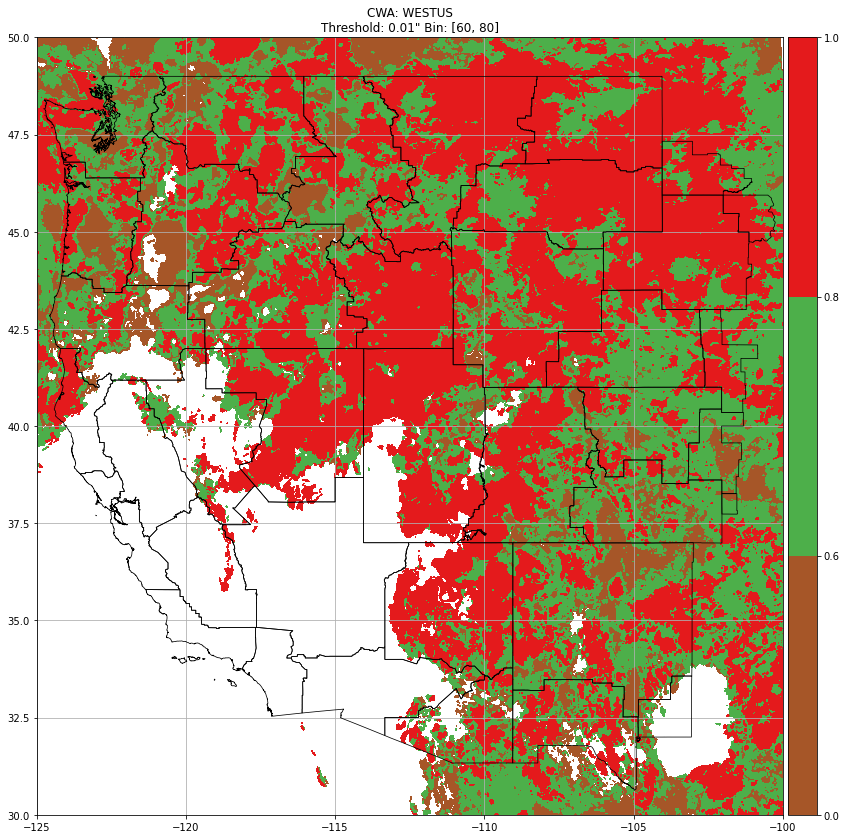

In [268]:
fig, ax = plt.subplots(1, figsize=(16, 16), facecolor='w')
ax.set_title('CWA: %s\nThreshold: %.02f" Bin: %s'%(cwa, thresh, pbins))

cwas.geometry.boundary.plot(color=None, edgecolor='black', linewidth=0.75, ax=ax)

data = xr.where(n > 5, n/N, np.nan)

levels = np.hstack([0, np.array(pbins), 100])/100
cbd = ax.contourf(data.lon, data.lat, data.values, levels=levels, cmap='Set1_r')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5)
plt.colorbar(cbd, cax=cax)
ax.grid(True, zorder=-10)

ax.set_ylim(bottom=30, top=50)
ax.set_xlim(left=-125, right=-100)

print(pbins)
plt.show()